In [0]:
!pip install dgl

     |████████████████████████████████| 3.0MB 2.5MB/s 


In [0]:
import dgl
import numpy as np
import pandas as pd


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [0]:
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

     |████████████████████████████████| 71kB 2.2MB/s 


In [0]:
df3=pd.read_csv("https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/estadoslatlon.csv")
df2=pd.read_csv('https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/DensPob.csv')
estados_list=df3["Estado"].to_list()
lat_list=df3["Lat"]
lon_list=df3['Long']


In [0]:
densidad=df2.sort_values(by=['Densidad'])
fig = px.bar(densidad, y="Estado", x="Densidad", orientation='h',height=800,width=800,labels={'Densidad':'Population Density [inhabitants per square km]','Estado':'State'})
fig.show()

In [0]:
G=dgl.DGLGraph()

In [0]:
G.add_nodes(32)

In [0]:
import numpy as np
def build_map():
  src=np.array([0 ,0 ,
                1 ,1 ,
                2 ,
                3 ,3 ,3 ,
                4 ,4 ,4 ,
                5 ,5 ,5 ,
                6 ,6 ,6 ,6 ,
                7 ,7 ,7 ,7 ,7 ,7 , 
                8 ,8 , 
                9 ,9 ,9 ,9 ,9 ,9 , 
                10 ,10 ,10 ,10 ,10 ,
                11 ,11 ,11 ,11 ,11 ,
                12 ,12 ,12 ,12 ,12 ,12 ,
                13 ,13 ,13 ,13 ,13 ,13 ,
                14  ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,
                15 , 15 ,15 ,15 ,15 ,15 ,
                16 ,16 ,16 ,16 ,
                17 ,17 ,17 , 
                18 ,18 ,18 ,
                19 ,19 ,19 ,19 ,
                20 ,20 ,20 ,20 ,20 ,20 ,20 , 
                21 ,21 ,21 ,21 ,21 ,
                22 ,22 ,
                23 ,23 ,23 ,23 ,23 ,23 ,
                24 ,24 ,24 ,24 ,
                25 ,25 ,25 ,
                26 ,26 ,26 ,
                27 ,27 ,27 ,
                28 ,28 ,28 ,
                29 ,29 ,29 ,29 ,29 ,29 ,
                30 ,30,
                31 ,31 ,31 ,31 ,31])
  dst=np.array([ 13, 31,
       2, 25,
       1,
       22, 26, 30,
       14, 16, 20,
       19, 26, 29,
       7, 9, 24, 25,
       6, 9, 31, 23, 18, 27,
       13, 15, 
       6, 7, 13, 17, 24, 31, 
       23, 31, 13, 15, 21,
       15, 14, 16, 20, 19, 
       29, 23, 21, 14, 28, 20,
       17, 31, 0, 10, 15, 8,
       21 , 10, 15, 11, 16, 4, 20, 28, 12,
       13,  8, 11, 14, 21, 10,
       11, 20, 4, 14,
       24, 9, 13, 
       7, 23, 27,
       11, 5, 29, 20,
       11, 19, 29, 12, 28, 14, 16, 
       23, 10, 15, 14, 12,
       3, 30,
       29, 27, 18, 31, 10, 21,
       25, 6, 9, 17,
       1, 6, 24,
       29, 5, 3,
       18, 23, 29,
       20, 14, 12,
       27, 23, 12, 20, 19, 26,
       3, 22,
       7, 9, 13, 0, 23])
  u=np.concatenate([src,dst])
  v=np.concatenate([dst,src])
  return dgl.DGLGraph((u,v))

In [0]:
G=build_map()

In [0]:
print(G.number_of_nodes())
print(G.number_of_edges())

32
264


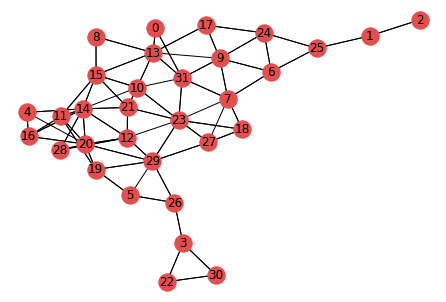

In [0]:
import networkx as nx
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(32, 32)  

In [0]:
x = torch.arange(0,32)
G.ndata['feat'] =torch.nn.functional.one_hot(x)

In [0]:
for i in range(32):
  G.ndata['feat'][i]=G.ndata['feat'][i]*df2['Densidad'][i]


print(G.ndata['feat'][31])

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 607])


In [0]:
from dgl.nn.pytorch import GraphConv


In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h


net = GCN(32, 5, 3)

In [0]:
inputs = embed.weight
labeled_nodes = torch.tensor([3,17,13,18,4,1])  
labels = torch.tensor([0,0,1,1,2,2])  

In [0]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(250):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.0478
Epoch 1 | Loss: 0.9744
Epoch 2 | Loss: 0.9072
Epoch 3 | Loss: 0.8473
Epoch 4 | Loss: 0.7915
Epoch 5 | Loss: 0.7406
Epoch 6 | Loss: 0.6932
Epoch 7 | Loss: 0.6479
Epoch 8 | Loss: 0.6055
Epoch 9 | Loss: 0.5658
Epoch 10 | Loss: 0.5287
Epoch 11 | Loss: 0.4942
Epoch 12 | Loss: 0.4617
Epoch 13 | Loss: 0.4304
Epoch 14 | Loss: 0.3999
Epoch 15 | Loss: 0.3713
Epoch 16 | Loss: 0.3446
Epoch 17 | Loss: 0.3201
Epoch 18 | Loss: 0.2965
Epoch 19 | Loss: 0.2734
Epoch 20 | Loss: 0.2515
Epoch 21 | Loss: 0.2307
Epoch 22 | Loss: 0.2114
Epoch 23 | Loss: 0.1935
Epoch 24 | Loss: 0.1769
Epoch 25 | Loss: 0.1609
Epoch 26 | Loss: 0.1464
Epoch 27 | Loss: 0.1327
Epoch 28 | Loss: 0.1195
Epoch 29 | Loss: 0.1072
Epoch 30 | Loss: 0.0955
Epoch 31 | Loss: 0.0847
Epoch 32 | Loss: 0.0748
Epoch 33 | Loss: 0.0658
Epoch 34 | Loss: 0.0576
Epoch 35 | Loss: 0.0504
Epoch 36 | Loss: 0.0439
Epoch 37 | Loss: 0.0383
Epoch 38 | Loss: 0.0333
Epoch 39 | Loss: 0.0290
Epoch 40 | Loss: 0.0252
Epoch 41 | Loss: 0.0220
Ep

In [0]:
import pandas as pd
df=pd.DataFrame(all_logits[249][:].numpy())

In [0]:
lista=[]
for i in range(32):
  lista.append((all_logits[249][i].numpy().argmax()))

df['li']=pd.Series(lista)

In [0]:
df['Lat']=lat_list
df['Long']=lon_list
df['Estado']=estados_list

In [0]:
df

,0,1,2,li,Lat,Long,Estado
0,2.983402,0.334820,-3.028219,0,26.930560,88.093590,ILAM_MECHI
1,-4.504746,-2.426033,7.720926,2,27.701671,83.465913,RUPANDEHI_LUMBINI
2,0.315176,-0.320955,-0.886030,0,27.753100,85.327400,KATHMANDU_BAGMATI
3,7.533384,-3.670802,-3.445478,0,28.754510,81.605620,DAILEKH_BHERI
4,-4.365326,-0.889479,6.802690,2,27.807100,82.625320,DANG_RAPTI
5,-0.070755,-1.420969,2.278777,2,27.698710,83.314770,RUPANDEHI_LUMBINI
6,3.274036,0.078732,-2.330700,0,27.822770,85.542270,SINDHUPALCHOK_BAGMATI
7,1.998973,3.948435,-3.300468,1,26.830283,87.287533,SUNSARI_KOSHI
8,0.421371,0.320485,0.047431,0,27.687305,84.263723,NAWALPARASI_LUMBINI
9,3.800134,2.505114,-4.739360,0,26.596200,87.273580,SUNSARI_KOSHI


In [0]:
fig = px.scatter_geo(df, lat="Lat",lon="Long", color='li',size=df['li']+1,
                     #animation_frame="Fecha",
                     scope='asia',#range_color=[0,max(todos['conteo'])],
                     center={'lat':28.7,'lon':85.3},width=1200, height=1200,text = df['Estado'],
                     projection="natural earth")


fig.show()